# Mixed States Reconstruction (Infidelity as loss)

In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [3]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation (Haar Distribution)

In [4]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [7]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [8]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [9]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [10]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [11]:
#define loss function
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)


   numer = tf.math.abs(tf.linalg.trace(tf.matmul(rho_a, rho_b)))
   den = tf.math.sqrt(tf.linalg.trace(tf.linalg.matmul(rho_a, rho_a)) * tf.linalg.trace(tf.linalg.matmul(rho_b, rho_b)))
   numer = tf.cast(numer, tf.complex64)
   infidelity = 1 - numer/den
   return infidelity

In [12]:
print(tf.math.abs(tf.linalg.trace(tf.matmul(Y_tf, Y_tf))))
print(tf.linalg.matmul(Y_tf, Y_tf))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]], shape=(2, 2), dtype=complex64)


In [13]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [14]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [15]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [16]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [17]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [18]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [19]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [20]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [21]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [22]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [23]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [24]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [25]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[600:800], bloch_vectors_with_noise[800:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[600:800], bloch_vectors_noise_free[800:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [26]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [27]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a *b
  return output

In [28]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(64, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) 
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal) #normal


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           256         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                                  
 vector (Dense)                 (None, 3)            195         ['dense_1[0][0]']                
                                                                                            

In [29]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=10, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 3s 127ms/step - loss: 0.2274 - val_loss: 0.1017
Epoch 2/1000
5/5 [==============================] - 0s 38ms/step - loss: 0.0709 - val_loss: 0.0417
Epoch 3/1000
5/5 [==============================] - 0s 38ms/step - loss: 0.0327 - val_loss: 0.0263
Epoch 4/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.0183 - val_loss: 0.0120
Epoch 5/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 6/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 10/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 11

5/5 [==============================] - 0s 28ms/step - loss: 2.6227e-05 - val_loss: 6.4310e-04
Epoch 79/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.5924e-05 - val_loss: 6.4957e-04
Epoch 80/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.4762e-05 - val_loss: 6.4419e-04
Epoch 81/1000
5/5 [==============================] - 0s 33ms/step - loss: 2.3839e-05 - val_loss: 6.3729e-04
Epoch 82/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.3162e-05 - val_loss: 6.3737e-04
Epoch 83/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.1704e-05 - val_loss: 6.3561e-04
Epoch 84/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.1460e-05 - val_loss: 6.4311e-04
Epoch 85/1000
5/5 [==============================] - 0s 33ms/step - loss: 2.0332e-05 - val_loss: 6.3366e-04
Epoch 86/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.9779e-05 - val_loss: 6.2180e-04
Epoch 87/1000
5/5 [=======================

5/5 [==============================] - 0s 37ms/step - loss: 2.5916e-06 - val_loss: 5.6617e-04
Epoch 154/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.5630e-06 - val_loss: 5.6426e-04
Epoch 155/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.4807e-06 - val_loss: 5.6400e-04
Epoch 156/1000
5/5 [==============================] - 0s 35ms/step - loss: 2.5249e-06 - val_loss: 5.5926e-04
Epoch 157/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.3592e-06 - val_loss: 5.6223e-04
Epoch 158/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.3532e-06 - val_loss: 5.6227e-04
Epoch 159/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.3985e-06 - val_loss: 5.6003e-04
Epoch 160/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.1780e-06 - val_loss: 5.6253e-04
Epoch 161/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.0897e-06 - val_loss: 5.5996e-04
Epoch 162/1000
5/5 [==============

5/5 [==============================] - 0s 38ms/step - loss: 4.6134e-07 - val_loss: 5.4499e-04
Epoch 229/1000
5/5 [==============================] - 0s 36ms/step - loss: 5.2571e-07 - val_loss: 5.4369e-04
Epoch 230/1000
5/5 [==============================] - 0s 36ms/step - loss: 5.1379e-07 - val_loss: 5.4665e-04
Epoch 231/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.9591e-07 - val_loss: 5.4349e-04
Epoch 232/1000
5/5 [==============================] - 0s 34ms/step - loss: 5.0426e-07 - val_loss: 5.4560e-04
Epoch 233/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.7445e-07 - val_loss: 5.4532e-04
Epoch 234/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.5538e-07 - val_loss: 5.4275e-04
Epoch 235/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.3392e-07 - val_loss: 5.4590e-04
Epoch 236/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.1008e-07 - val_loss: 5.4504e-04
Epoch 237/1000
5/5 [==============

5/5 [==============================] - 0s 32ms/step - loss: 1.7524e-07 - val_loss: 5.4158e-04
Epoch 304/1000
5/5 [==============================] - 0s 37ms/step - loss: 1.7047e-07 - val_loss: 5.4035e-04
Epoch 305/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.3590e-07 - val_loss: 5.4168e-04
Epoch 306/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.4782e-07 - val_loss: 5.4053e-04
Epoch 307/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.7047e-07 - val_loss: 5.4079e-04
Epoch 308/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.6451e-07 - val_loss: 5.4193e-04
Epoch 309/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.4663e-07 - val_loss: 5.4026e-04
Epoch 310/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.6093e-07 - val_loss: 5.4059e-04
Epoch 311/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.6093e-07 - val_loss: 5.3922e-04
Epoch 312/1000
5/5 [==============

5/5 [==============================] - 0s 29ms/step - loss: 3.9339e-08 - val_loss: 5.3978e-04
Epoch 379/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.3181e-08 - val_loss: 5.3910e-04
Epoch 380/1000
5/5 [==============================] - 0s 38ms/step - loss: 8.1062e-08 - val_loss: 5.3947e-04
Epoch 381/1000
5/5 [==============================] - 0s 36ms/step - loss: 4.5300e-08 - val_loss: 5.4030e-04
Epoch 382/1000
5/5 [==============================] - 0s 36ms/step - loss: 4.7684e-08 - val_loss: 5.3872e-04
Epoch 383/1000
5/5 [==============================] - 0s 36ms/step - loss: 4.6492e-08 - val_loss: 5.3921e-04
Epoch 384/1000
5/5 [==============================] - 0s 37ms/step - loss: 4.7684e-08 - val_loss: 5.3904e-04
Epoch 385/1000
5/5 [==============================] - 0s 28ms/step - loss: 6.6757e-08 - val_loss: 5.3906e-04
Epoch 386/1000
5/5 [==============================] - 0s 40ms/step - loss: 4.7684e-08 - val_loss: 5.3863e-04
Epoch 387/1000
5/5 [==============

5/5 [==============================] - 0s 30ms/step - loss: 1.6451e-07 - val_loss: 5.3878e-04
Epoch 454/1000
5/5 [==============================] - 0s 33ms/step - loss: 1.9670e-07 - val_loss: 5.3893e-04
Epoch 455/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.2636e-07 - val_loss: 5.4217e-04
Epoch 456/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.5259e-07 - val_loss: 5.3712e-04
Epoch 457/1000
5/5 [==============================] - 0s 33ms/step - loss: 1.1325e-07 - val_loss: 5.3814e-04
Epoch 458/1000
5/5 [==============================] - 0s 32ms/step - loss: 9.1791e-08 - val_loss: 5.3599e-04
Epoch 459/1000
5/5 [==============================] - 0s 34ms/step - loss: 5.1260e-08 - val_loss: 5.3809e-04
Epoch 460/1000
5/5 [==============================] - 0s 36ms/step - loss: 4.8876e-08 - val_loss: 5.3827e-04
Epoch 461/1000
5/5 [==============================] - 0s 38ms/step - loss: 3.6955e-08 - val_loss: 5.3780e-04
Epoch 462/1000
5/5 [==============

5/5 [==============================] - 0s 30ms/step - loss: 4.7803e-07 - val_loss: 5.3500e-04
Epoch 529/1000
5/5 [==============================] - 0s 37ms/step - loss: 6.3419e-07 - val_loss: 5.2801e-04
Epoch 530/1000
5/5 [==============================] - 0s 31ms/step - loss: 6.3896e-07 - val_loss: 5.3488e-04
Epoch 531/1000
5/5 [==============================] - 0s 34ms/step - loss: 5.6386e-07 - val_loss: 5.3083e-04
Epoch 532/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.5327e-07 - val_loss: 5.4367e-04
Epoch 533/1000
5/5 [==============================] - 0s 32ms/step - loss: 6.8545e-07 - val_loss: 5.3203e-04
Epoch 534/1000
5/5 [==============================] - 0s 32ms/step - loss: 8.9765e-07 - val_loss: 5.4359e-04
Epoch 535/1000
5/5 [==============================] - 0s 36ms/step - loss: 7.5817e-07 - val_loss: 5.2778e-04
Epoch 536/1000
5/5 [==============================] - 0s 39ms/step - loss: 6.6757e-07 - val_loss: 5.3823e-04
Epoch 537/1000
5/5 [==============

5/5 [==============================] - 0s 36ms/step - loss: 1.1824e-04 - val_loss: 6.1711e-04
Epoch 604/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.7183e-04 - val_loss: 7.4048e-04
Epoch 605/1000
5/5 [==============================] - 0s 33ms/step - loss: 2.4595e-04 - val_loss: 9.2229e-04
Epoch 606/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.3166e-04 - val_loss: 6.2210e-04
Epoch 607/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.3754e-04 - val_loss: 6.3312e-04
Epoch 608/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.2616e-04 - val_loss: 0.0015
Epoch 609/1000
5/5 [==============================] - 0s 30ms/step - loss: 9.0306e-04 - val_loss: 0.0014
Epoch 610/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.0013 - val_loss: 9.0811e-04
Epoch 611/1000
5/5 [==============================] - 0s 32ms/step - loss: 9.0964e-04 - val_loss: 5.5944e-04
Epoch 612/1000
5/5 [==========================

5/5 [==============================] - 0s 36ms/step - loss: 3.1829e-07 - val_loss: 4.0100e-04
Epoch 679/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.4915e-07 - val_loss: 3.9633e-04
Epoch 680/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.8253e-07 - val_loss: 4.0095e-04
Epoch 681/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.6584e-07 - val_loss: 3.9862e-04
Epoch 682/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.3617e-07 - val_loss: 4.0130e-04
Epoch 683/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.6703e-07 - val_loss: 3.9563e-04
Epoch 684/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.8028e-07 - val_loss: 4.0140e-04
Epoch 685/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.3961e-07 - val_loss: 3.9882e-04
Epoch 686/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.3007e-07 - val_loss: 3.9916e-04
Epoch 687/1000
5/5 [==============

5/5 [==============================] - 0s 30ms/step - loss: 8.7023e-08 - val_loss: 3.9998e-04
Epoch 754/1000
5/5 [==============================] - 0s 32ms/step - loss: 7.7486e-08 - val_loss: 3.9932e-04
Epoch 755/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.3181e-08 - val_loss: 3.9990e-04
Epoch 756/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.2915e-08 - val_loss: 3.9900e-04
Epoch 757/1000
5/5 [==============================] - 0s 30ms/step - loss: 7.3910e-08 - val_loss: 3.9966e-04
Epoch 758/1000
5/5 [==============================] - 0s 29ms/step - loss: 7.0333e-08 - val_loss: 3.9901e-04
Epoch 759/1000
5/5 [==============================] - 0s 30ms/step - loss: 9.2983e-08 - val_loss: 4.0050e-04
Epoch 760/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.6212e-07 - val_loss: 4.0030e-04
Epoch 761/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.2159e-07 - val_loss: 3.9793e-04
Epoch 762/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 1.1623e-06 - val_loss: 4.0714e-04
Epoch 829/1000
5/5 [==============================] - 0s 41ms/step - loss: 1.0872e-06 - val_loss: 4.0030e-04
Epoch 830/1000
5/5 [==============================] - 0s 34ms/step - loss: 7.4029e-07 - val_loss: 3.9507e-04
Epoch 831/1000
5/5 [==============================] - 0s 32ms/step - loss: 4.8876e-07 - val_loss: 3.8977e-04
Epoch 832/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.4002e-07 - val_loss: 3.9221e-04
Epoch 833/1000
5/5 [==============================] - 0s 30ms/step - loss: 7.3910e-07 - val_loss: 3.9609e-04
Epoch 834/1000
5/5 [==============================] - 0s 31ms/step - loss: 6.8665e-07 - val_loss: 4.0130e-04
Epoch 835/1000
5/5 [==============================] - 0s 34ms/step - loss: 7.4029e-07 - val_loss: 3.9210e-04
Epoch 836/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.3924e-06 - val_loss: 4.0468e-04
Epoch 837/1000
5/5 [==============

5/5 [==============================] - 0s 36ms/step - loss: 4.7958e-06 - val_loss: 3.3956e-04
Epoch 904/1000
5/5 [==============================] - 0s 38ms/step - loss: 3.6240e-06 - val_loss: 3.1671e-04
Epoch 905/1000
5/5 [==============================] - 0s 38ms/step - loss: 3.0267e-06 - val_loss: 3.4029e-04
Epoch 906/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.8181e-06 - val_loss: 3.2564e-04
Epoch 907/1000
5/5 [==============================] - 0s 40ms/step - loss: 2.3150e-06 - val_loss: 3.1439e-04
Epoch 908/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.7548e-06 - val_loss: 3.1486e-04
Epoch 909/1000
5/5 [==============================] - 0s 38ms/step - loss: 2.4021e-06 - val_loss: 3.2858e-04
Epoch 910/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.1422e-06 - val_loss: 3.0133e-04
Epoch 911/1000
5/5 [==============================] - 0s 29ms/step - loss: 3.4010e-06 - val_loss: 3.3865e-04
Epoch 912/1000
5/5 [==============

5/5 [==============================] - 0s 39ms/step - loss: 2.5630e-07 - val_loss: 3.1583e-04
Epoch 979/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.4796e-07 - val_loss: 3.1417e-04
Epoch 980/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.1577e-07 - val_loss: 3.2004e-04
Epoch 981/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.5868e-07 - val_loss: 3.1299e-04
Epoch 982/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.6464e-07 - val_loss: 3.1687e-04
Epoch 983/1000
5/5 [==============================] - 0s 33ms/step - loss: 2.9683e-07 - val_loss: 3.2226e-04
Epoch 984/1000
5/5 [==============================] - 0s 32ms/step - loss: 4.8280e-07 - val_loss: 3.1681e-04
Epoch 985/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.0756e-07 - val_loss: 3.1452e-04
Epoch 986/1000
5/5 [==============================] - 0s 37ms/step - loss: 2.3842e-07 - val_loss: 3.1840e-04
Epoch 987/1000
5/5 [==============

In [30]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

7/7 - 0s - loss: 2.4073e-04 - 348ms/epoch - 50ms/step


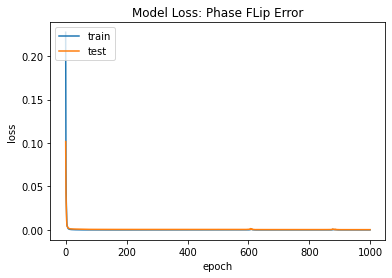

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9997990066395657-1.8189757848680432e-09j), shape=(), dtype=complex128)


(0.9999630603052838-2.972742717448783e-08j)
tf.Tensor([-0.04565412+0.j -0.02419375+0.j -0.08327027+0.j], shape=(3,), dtype=complex64)
tf.Tensor([-0.03471306+0.j -0.02344652+0.j -0.08859368+0.j], shape=(3,), dtype=complex64)


C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:564: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:565: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asarray(self.convert_yunits(offsets[:, 1]), 'float')))
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\colors.py:277: ComplexWarning: Casting complex values to real discard

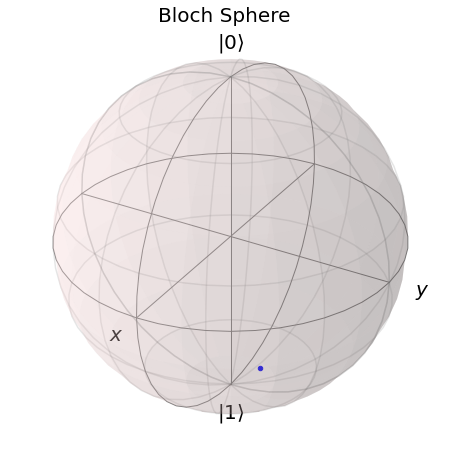

In [33]:
den_mat = rho_from_vec(y_prediction[0])
den_mat = np.asarray(den_mat)

den_mat_id = rho_from_vec(y_test[0])
den_mat_id = np.asarray(den_mat_id)

print(fidelity_function(den_mat_id, den_mat))


print(y_prediction[0])
print(y_test[0])

Bloch_sphere(y_prediction[1:2])

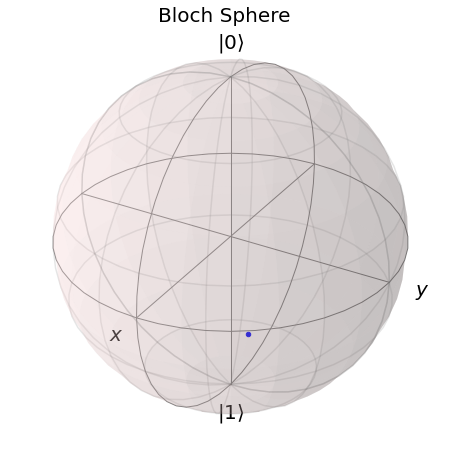

In [34]:
Bloch_sphere(x_test[1:2])

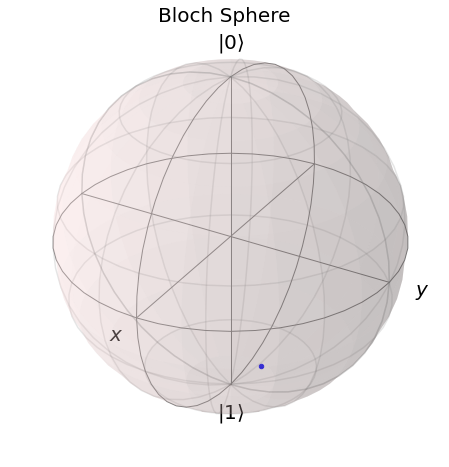

In [35]:
Bloch_sphere(y_test[1:2])

## Test with Alternative Fidelity

In [36]:
@tf.function
def inf_vec(a,b):
    fid = 0.5 * (1 + tf.tensordot(a, b, 1) + ((1 - tf.tensordot(a, a, 1))*(1 - tf.tensordot(b, b, 1)))**(1/2))
    return 1 - fid

In [39]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [40]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 1s 85ms/step - loss: 0.2420 - val_loss: 0.2325
Epoch 2/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.2199 - val_loss: 0.2124
Epoch 3/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.1990 - val_loss: 0.1939
Epoch 4/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.1807 - val_loss: 0.1770
Epoch 5/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.1624 - val_loss: 0.1619
Epoch 6/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.1468 - val_loss: 0.1479
Epoch 7/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.1332 - val_loss: 0.1349
Epoch 8/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.1202 - val_loss: 0.1230
Epoch 9/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.1081 - val_loss: 0.1124
Epoch 10/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0978 - val_loss: 0.1025
Epoch 11/

Epoch 82/1000
5/5 [==============================] - 0s 32ms/step - loss: 5.5637e-04 - val_loss: 0.0011
Epoch 83/1000
5/5 [==============================] - 0s 27ms/step - loss: 5.4895e-04 - val_loss: 0.0011
Epoch 84/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.4095e-04 - val_loss: 0.0011
Epoch 85/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.3292e-04 - val_loss: 0.0011
Epoch 86/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.2711e-04 - val_loss: 0.0011
Epoch 87/1000
5/5 [==============================] - 0s 39ms/step - loss: 5.2069e-04 - val_loss: 0.0010
Epoch 88/1000
5/5 [==============================] - 0s 40ms/step - loss: 5.1335e-04 - val_loss: 0.0010
Epoch 89/1000
5/5 [==============================] - 0s 26ms/step - loss: 5.0664e-04 - val_loss: 0.0010
Epoch 90/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.9953e-04 - val_loss: 0.0010
Epoch 91/1000
5/5 [==============================] - 0s 28ms/ste

Epoch 158/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.6449e-04 - val_loss: 7.5528e-04
Epoch 159/1000
5/5 [==============================] - 0s 27ms/step - loss: 2.6255e-04 - val_loss: 7.5008e-04
Epoch 160/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.6155e-04 - val_loss: 7.4655e-04
Epoch 161/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.5918e-04 - val_loss: 7.4635e-04
Epoch 162/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5767e-04 - val_loss: 7.4209e-04
Epoch 163/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.5622e-04 - val_loss: 7.3993e-04
Epoch 164/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.5395e-04 - val_loss: 7.4165e-04
Epoch 165/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5217e-04 - val_loss: 7.3736e-04
Epoch 166/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.5022e-04 - val_loss: 7.3709e-04
Epoch 167/1000
5/5 

5/5 [==============================] - 0s 30ms/step - loss: 1.6858e-04 - val_loss: 6.2404e-04
Epoch 234/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.6793e-04 - val_loss: 6.2097e-04
Epoch 235/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.6736e-04 - val_loss: 6.2264e-04
Epoch 236/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.6657e-04 - val_loss: 6.2531e-04
Epoch 237/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.6670e-04 - val_loss: 6.2688e-04
Epoch 238/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.6502e-04 - val_loss: 6.2077e-04
Epoch 239/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.6414e-04 - val_loss: 6.1652e-04
Epoch 240/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.6441e-04 - val_loss: 6.1572e-04
Epoch 241/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.6287e-04 - val_loss: 6.1297e-04
Epoch 242/1000
5/5 [==============

5/5 [==============================] - 0s 28ms/step - loss: 1.2148e-04 - val_loss: 5.5041e-04
Epoch 309/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.2139e-04 - val_loss: 5.4844e-04
Epoch 310/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2059e-04 - val_loss: 5.4653e-04
Epoch 311/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2053e-04 - val_loss: 5.4818e-04
Epoch 312/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.2104e-04 - val_loss: 5.3889e-04
Epoch 313/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.1908e-04 - val_loss: 5.4437e-04
Epoch 314/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1936e-04 - val_loss: 5.4562e-04
Epoch 315/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.1897e-04 - val_loss: 5.4616e-04
Epoch 316/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1748e-04 - val_loss: 5.4213e-04
Epoch 317/1000
5/5 [==============

5/5 [==============================] - 0s 36ms/step - loss: 8.8438e-05 - val_loss: 4.9159e-04
Epoch 384/1000
5/5 [==============================] - 0s 27ms/step - loss: 8.6491e-05 - val_loss: 4.8915e-04
Epoch 385/1000
5/5 [==============================] - 0s 28ms/step - loss: 8.7216e-05 - val_loss: 4.9062e-04
Epoch 386/1000
5/5 [==============================] - 0s 30ms/step - loss: 8.5477e-05 - val_loss: 4.8850e-04
Epoch 387/1000
5/5 [==============================] - 0s 37ms/step - loss: 8.6855e-05 - val_loss: 4.8841e-04
Epoch 388/1000
5/5 [==============================] - 0s 32ms/step - loss: 8.5070e-05 - val_loss: 4.8459e-04
Epoch 389/1000
5/5 [==============================] - 0s 30ms/step - loss: 8.4807e-05 - val_loss: 4.8681e-04
Epoch 390/1000
5/5 [==============================] - 0s 28ms/step - loss: 8.3861e-05 - val_loss: 4.8803e-04
Epoch 391/1000
5/5 [==============================] - 0s 26ms/step - loss: 8.3617e-05 - val_loss: 4.8529e-04
Epoch 392/1000
5/5 [==============

5/5 [==============================] - 0s 28ms/step - loss: 6.0420e-05 - val_loss: 4.5019e-04
Epoch 459/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.1045e-05 - val_loss: 4.5414e-04
Epoch 460/1000
5/5 [==============================] - 0s 32ms/step - loss: 6.0669e-05 - val_loss: 4.5543e-04
Epoch 461/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.9596e-05 - val_loss: 4.4689e-04
Epoch 462/1000
5/5 [==============================] - 0s 29ms/step - loss: 6.1044e-05 - val_loss: 4.4610e-04
Epoch 463/1000
5/5 [==============================] - 0s 31ms/step - loss: 6.1587e-05 - val_loss: 4.5206e-04
Epoch 464/1000
5/5 [==============================] - 0s 33ms/step - loss: 5.9223e-05 - val_loss: 4.5310e-04
Epoch 465/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.9152e-05 - val_loss: 4.4670e-04
Epoch 466/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.8769e-05 - val_loss: 4.4662e-04
Epoch 467/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 4.5226e-05 - val_loss: 4.2242e-04
Epoch 534/1000
5/5 [==============================] - 0s 33ms/step - loss: 4.4696e-05 - val_loss: 4.2617e-04
Epoch 535/1000
5/5 [==============================] - 0s 36ms/step - loss: 4.5702e-05 - val_loss: 4.2038e-04
Epoch 536/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.4799e-05 - val_loss: 4.1948e-04
Epoch 537/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.4906e-05 - val_loss: 4.2268e-04
Epoch 538/1000
5/5 [==============================] - 0s 32ms/step - loss: 4.4349e-05 - val_loss: 4.2120e-04
Epoch 539/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.4057e-05 - val_loss: 4.2076e-04
Epoch 540/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.3906e-05 - val_loss: 4.2085e-04
Epoch 541/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.4297e-05 - val_loss: 4.2354e-04
Epoch 542/1000
5/5 [==============

5/5 [==============================] - 0s 32ms/step - loss: 3.3995e-05 - val_loss: 4.0737e-04
Epoch 609/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.4789e-05 - val_loss: 4.0990e-04
Epoch 610/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.3896e-05 - val_loss: 4.0384e-04
Epoch 611/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.3613e-05 - val_loss: 3.9877e-04
Epoch 612/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.3925e-05 - val_loss: 3.9920e-04
Epoch 613/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.4143e-05 - val_loss: 4.0904e-04
Epoch 614/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.3828e-05 - val_loss: 4.0417e-04
Epoch 615/1000
5/5 [==============================] - 0s 35ms/step - loss: 3.4878e-05 - val_loss: 4.0579e-04
Epoch 616/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.2705e-05 - val_loss: 3.9959e-04
Epoch 617/1000
5/5 [==============

5/5 [==============================] - 0s 26ms/step - loss: 2.6299e-05 - val_loss: 3.8564e-04
Epoch 684/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.5493e-05 - val_loss: 3.8151e-04
Epoch 685/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.5691e-05 - val_loss: 3.8293e-04
Epoch 686/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.5966e-05 - val_loss: 3.8797e-04
Epoch 687/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.6112e-05 - val_loss: 3.7401e-04
Epoch 688/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.6430e-05 - val_loss: 3.9207e-04
Epoch 689/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.6609e-05 - val_loss: 3.8270e-04
Epoch 690/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5235e-05 - val_loss: 3.7698e-04
Epoch 691/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.5425e-05 - val_loss: 3.8504e-04
Epoch 692/1000
5/5 [==============

5/5 [==============================] - 0s 30ms/step - loss: 1.9865e-05 - val_loss: 3.6985e-04
Epoch 759/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.9153e-05 - val_loss: 3.5797e-04
Epoch 760/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.9752e-05 - val_loss: 3.5975e-04
Epoch 761/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.8079e-05 - val_loss: 3.6585e-04
Epoch 762/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.9100e-05 - val_loss: 3.5755e-04
Epoch 763/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.9385e-05 - val_loss: 3.5201e-04
Epoch 764/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.9162e-05 - val_loss: 3.5842e-04
Epoch 765/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.8724e-05 - val_loss: 3.6362e-04
Epoch 766/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.8376e-05 - val_loss: 3.4990e-04
Epoch 767/1000
5/5 [==============

5/5 [==============================] - 0s 29ms/step - loss: 1.5293e-05 - val_loss: 3.3593e-04
Epoch 834/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.7109e-05 - val_loss: 3.4541e-04
Epoch 835/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.7301e-05 - val_loss: 3.3059e-04
Epoch 836/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.5996e-05 - val_loss: 3.5302e-04
Epoch 837/1000
5/5 [==============================] - 0s 33ms/step - loss: 1.4755e-05 - val_loss: 3.3898e-04
Epoch 838/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.5413e-05 - val_loss: 3.3479e-04
Epoch 839/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.4437e-05 - val_loss: 3.3739e-04
Epoch 840/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.5547e-05 - val_loss: 3.4249e-04
Epoch 841/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.4431e-05 - val_loss: 3.3636e-04
Epoch 842/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 1.1934e-05 - val_loss: 3.2890e-04
Epoch 909/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.2206e-05 - val_loss: 3.1564e-04
Epoch 910/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.1950e-05 - val_loss: 3.2377e-04
Epoch 911/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.1935e-05 - val_loss: 3.2193e-04
Epoch 912/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.0906e-05 - val_loss: 3.2576e-04
Epoch 913/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1567e-05 - val_loss: 3.1938e-04
Epoch 914/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.2398e-05 - val_loss: 3.2309e-04
Epoch 915/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1755e-05 - val_loss: 3.2155e-04
Epoch 916/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.1747e-05 - val_loss: 3.2375e-04
Epoch 917/1000
5/5 [==============

5/5 [==============================] - 0s 31ms/step - loss: 9.5034e-06 - val_loss: 3.1535e-04
Epoch 984/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.0437e-05 - val_loss: 3.1069e-04
Epoch 985/1000
5/5 [==============================] - 0s 32ms/step - loss: 9.5415e-06 - val_loss: 3.1707e-04
Epoch 986/1000
5/5 [==============================] - 0s 34ms/step - loss: 9.6595e-06 - val_loss: 3.0673e-04
Epoch 987/1000
5/5 [==============================] - 0s 34ms/step - loss: 9.4652e-06 - val_loss: 3.1460e-04
Epoch 988/1000
5/5 [==============================] - 0s 36ms/step - loss: 9.4247e-06 - val_loss: 3.0989e-04
Epoch 989/1000
5/5 [==============================] - 0s 31ms/step - loss: 9.3162e-06 - val_loss: 3.0995e-04
Epoch 990/1000
5/5 [==============================] - 0s 34ms/step - loss: 9.6118e-06 - val_loss: 3.1246e-04
Epoch 991/1000
5/5 [==============================] - 0s 35ms/step - loss: 9.4402e-06 - val_loss: 3.0670e-04
Epoch 992/1000
5/5 [==============

In [41]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9982434077508074-2.204386870400859e-09j), shape=(), dtype=complex128)
